# The Timeseries Sidekick Quantum Autoencoder 
*TS QAE in PennyLane with angle encoding of TS sliding windows*

**By:** Jacob Cybulski, Arturk Strąg and Jakub Zwoniarski<br>
**Date:** August 2023 - September 2025<br>
**Aims:**
- The goal of this notebook is to build a TS QAE by training Sidekick QAE.
- The models are to be build and tested in PennyLane.
- In this notebook data is generated and parameters are not saved.
- The notebook has lots of additional tests and serves training objectives.
- All such tests can be disabled by setting option debug=False.

**Sources:**
1. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.
2. Ali Shannon, "techshot25/Autoencoders", accessed March 12, 2024, https://github.com/techshot25/Autoencoders.
3. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
4. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.

**Notes:**
- Refer to a separate "versions" notebook for the log of changes
- Why training Sidekick rather than Stacked QAE. In the Stacked QAE we measure the outcome of the half-QAE and QAE rather than using SWAP test. It means that during the half-QAE measurement we lose the phase information that normally flows through the latent phase. When using SWAP test, phase is used during the comparison of qubit states and accumulated in the ancilla qubit. Such an approach should (in theory) lead to better training (even though it may be slower). However, the cost function based on SWAP test never refers to the values of qubits themselves. This means that in the process of their linear transformation, the range of values may actually change!
- As the Sidekick model is difficult, and we need to carefully consider its structure and training
  - Sidekick consists of data encoding, the QAE encoder, latent / trash space, and QAE decoder
  - Data is angle encoded, one window value per qubit
  - QAE decoder is a mirror image of the QAE encoder, but they use different parameters
  - Trash space qubits are reset to zero, so the latent space compressed input
- The training regime is in three stages.
  - Stage 1: we train an adjoint of the decoder, which takes clean data, and I am using SWAP test to minimise trash space. In this way, the adjoint of the QAE decoder will learn how to recognise clean data. The common sense dictates that the better training is achieved in Stage 1, the better outcomes of Stages 2 and 3.
  - Stage 2: we train the sidekick model, which consists of the previously trained inverted QAE decoder, a QAE encoder in parallel qubits, and the latent spaces of are linked with a SWAP test. The circuit has double the number of qubits needed for each QAE encoder and decoder, plus an ancila qubit to measure SWAP outcome. The data used by the sidekick model is a pair of windows, the window with clean data for the inverted QAE decoder, and a window with different noise injected at each training iteration for the QAE encoder. In this way the model will not be learning a specific noise. In stage 2, we will train the encoder to compress noisy input to match the compressed representation of the clean data.
  - Stage 3: we create the full QAE which consists of the data encoder, the previously trained QAE encoder, the latent and trash space, and the the previously trained QAE decoder. Both the encoder and decoder will use their respective optimum parameters.
  - In stage 1 and 2 the SWAP test ancila qubits are measured with the cost function 1-P(|1>).
  - In stage 3 all data qubits are measured in terms of expectation values.
- Considerations.
  - In training our cost function never refers to the actual time series values. Therefore, our data encoding must be such that it spans the entire range of amplitudes. Otherwise in stage 3, the values measured as expectation values will shrink and shift in proportion between encoding range and the range of expectation values. The suggestion is to recode values from the range [0, 1] to the range [0, pi]. The final values will need to be scaled back to the range [0, 1].
  - When we train the inverted decoder in stage 1 we will pass in directly encoded values in. When we reintegrate the decoder into the full QAE we also need to invert the resulting data. This can be achieved with PauliX before measurement.
  - Note that we are injecting Gaussian noise to values in the range [0, 1], scaled by 0.2 (so this is a lot of noise). Now the problem we have is as follows. If we reduce the data value range to [0+margin, 1-margin] and then encode it, it will create the scaling problem at the end as the margin will upset the mapping into the expectation values [-1, 1]. If we decide to clip the noisy data to a range [0, 1] this creates a lot of values 0 or 1 in our training data, which are not representative of the clean data. If we leave the noisy values as they are then the range of values does not fit into [0, 1] interval, which then gets encoded not in the range [0, pi] but [-max noise, pi+max noise] casing issues in training. So this way of injecting noise is not idea. A better way would be to add noise in logit space, which would ensure all values fit the range [0, 1].
- Applied! The Sidekick parameter initialisation used the pre-trained weights for the inverted decoder and random weights for the encoder. I thought it would be better to initialise the encoder with the weights of the decoder. This would possibly start at the point of full value recovery in the absence of trash. From the opytimisation viewpoint, such initial weight values could be closer to the optimum than for a totally random initialisation.
- Fixed! There was some random effect happening in model training that is not well controlled by this code, so results are different every time.
- Finally, as the full variation of Sidekick's parameters is not possible, hence, it is expected that its performance will not be better than that of the Monolith model.

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl_test/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl_test/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl_test/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl_test/lib/python3.11/site-packages',
 '.',
 '..']

*For some inexplicable reason, "import __<font color="red">torch</font>__" made "lightning-qubit" very fast,*<br>
*even though torch functions were not used (directly).*

In [2]:
### Imports
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import time
import pennylane as qml
import torch
from pennylane import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from qae_utils.Tools import draw_circuit
from qae_utils.Charts import plot_hist, meas_plot, multi_plot_flat_ts
from qae_utils.Files import create_folder_if_needed, write_json_file, write_ts_file
from qae_utils.Window import ts_add_noise, ts_wind_make, ts_wind_split, ts_wind_flatten_avg

# <font color="blue">Settings</font>

In [3]:
### Debug control
#   Switch to false to remove testing
debug = True

In [4]:
### Data settings

# Window settings
# - Intentionally selected as difficult
# - it means with step > 1
wind_size = 6
wind_step = 2
horizon = 1
noise = 0.2
split = 0.75

# Mackey-Glass data 
beta=0.17    # Larger beta = stronger oscillations
gamma=0.1    # Keeps damping moderate
n=10         # Standard nonlinearity
tau=30       # Introduces chaos (try 17–30 for interesting behavior)
x0=1.2       # Initial condition
length=1200  # Length of the generated series (to be shrunk to 200)

### Random seed(s)
seed = 2025

In [5]:
### Model and training setting
np.random.seed(seed)

# Simulator settings
#   On JC machine default is 10 times faster
sim = 'lightning.qubit' # 'default.qubit' # 
shots = None

# QAE settings
# - Intentionally selected as difficult
# - it means larger latent than trash space for 
#   synchronisation of sidekick encoder and decoder
n_wires = wind_size
n_latent = 4
n_trash  = n_wires - n_latent
n_layers = 4
n_inv_decoder_epochs = 200
n_sidekick_epochs = 500
n_inv_decoder_lr = 0.1
n_sidekick_lr = 0.01
rot = 'Rxyz'
weight_scaler = 0.05
interface= 'autograd' # 'torch' # 
diff_method= 'adjoint' # 'parameter-shift' # 

# Data encoding setting
# - X is relevant to plotting only
# - Only y are used in windows
X_from = 0
X_to =   2*np.pi

# We need range 0..pi for sidekick encoding
# - Noise will be clipped to this range
#   which will falsify the value distribution
#   and lower the recovered values
y_margin = 0.0
y_low =  0+y_margin
y_high = np.pi-y_margin

## Utilities

In [6]:
##### Random seed generator
def rand_seed():
    t=time.time(); t = int((t-int(t))*10000)
    return t

In [7]:
##### Data scaler
def scale_values(x, new_min=0, new_max=1):
    scaler = MinMaxScaler(feature_range=(new_min, new_max))
    return scaler.fit_transform(x.reshape(-1, 1)).flatten()

# <font color="blue">Data preparation</font>

## <font color="red">Mackie-Glass dataset</font>

In [8]:
### Simulates the Mackey-Glass time series
def mackey_glass(length=1300, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(length + tau + 1, dtype=float)
    x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]
        xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx
    return x[tau+1:]

# Generate the Mackey-Glass time series
y_raw = mackey_glass(length=length, beta=beta, gamma=gamma, n=n, tau=tau, x0=x0)
y_raw = scale_values(y_raw, new_min=y_low, new_max=y_high)
y = y_raw[3::6] # reduce the number of points but keep the shape
X_raw = np.array([i for i in range(len(y))]) # Number points
X = scale_values(X_raw, new_min=X_from, new_max=X_to) # Keep the original coords

n_samples = len(y)

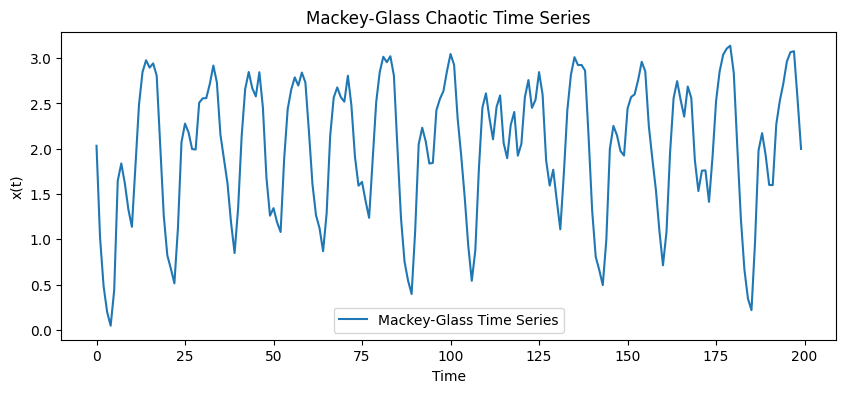

In [9]:
### Plot the Mackey-Glass time series
plt.figure(figsize=(10, 4))
plt.plot(y, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

### Prepare data for training

In [10]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2, range_low=0.2, range_high=0.8, seed=0):
    y_noisy = ts_add_noise(y, noise=noise, noise_type='normal', clip=True,
        range_low=range_low, range_high=range_high, seed=seed)
    y_ts = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = ts_wind_make(X, wind_size, wind_step)
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [11]:
from pprint import pprint

### Create windows and split into training and test partitions
X_train_coords, y_train_coords, X_test_coords, y_test_coords = \
        create_sw_tens(X, X, noise=0.0, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)
X_train_tens, y_train_tens, X_test_tens, y_test_tens = \
    create_sw_tens(y, y, noise=0.0, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)
_, X_train_noisy_tens, _, X_test_noisy_tens = \
    create_sw_tens(y, y, noise=noise, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)

### Find partition sizes
n_train = len(X_train_tens)
n_test = len(X_test_tens)

### Print a sample of data
print('\nSample of training partition:\n\nWindow coordinates:')
pprint(X_train_coords[0:3])
print('\nWindow values:')
pprint(X_train_tens[0:3]); 
print('\nSample of test partition:\n\nWindow coordinates:')
pprint(X_test_coords[0:3])
print('\nWindow values:')
pprint(X_test_tens[0:3]); print()


Sample of training partition:

Window coordinates:
tensor([[0.        , 0.0315738 , 0.06314759, 0.09472139, 0.12629518,
         0.15786898],
        [0.06314759, 0.09472139, 0.12629518, 0.15786898, 0.18944277,
         0.22101657],
        [0.12629518, 0.15786898, 0.18944277, 0.22101657, 0.25259036,
         0.28416416]], requires_grad=False)

Window values:
tensor([[2.03261365, 1.02141319, 0.48401981, 0.19842693, 0.04665116,
         0.44105611],
        [0.48401981, 0.19842693, 0.04665116, 0.44105611, 1.64625959,
         1.8373525 ],
        [0.04665116, 0.44105611, 1.64625959, 1.8373525 , 1.61852219,
         1.33038146]], requires_grad=False)

Sample of test partition:

Window coordinates:
tensor([[4.67292174, 4.70449553, 4.73606933, 4.76764312, 4.79921692,
         4.83079071],
        [4.73606933, 4.76764312, 4.79921692, 4.83079071, 4.86236451,
         4.8939383 ],
        [4.79921692, 4.83079071, 4.86236451, 4.8939383 , 4.9255121 ,
         4.9570859 ]], requires_grad=False)

### Plot flattened windows with sample noise
- Noise was clipped not to exceed the range [0..pi]

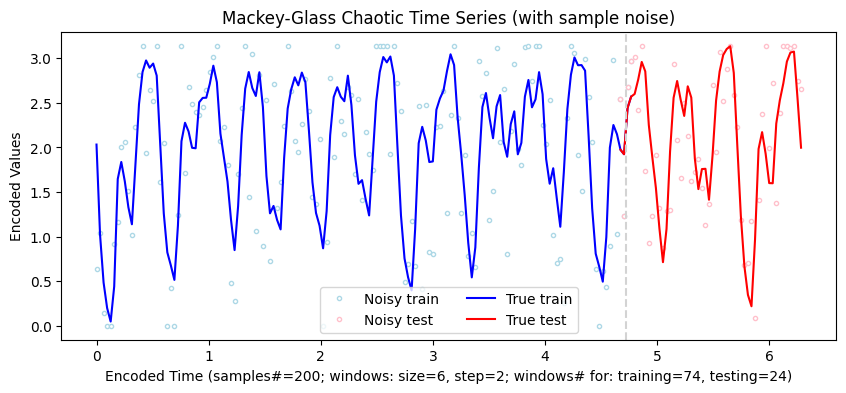

In [12]:
### Flatten windows by averaging overlapping data
X_train_flat_ts = ts_wind_flatten_avg(X_train_tens, wind_step)
X_test_flat_ts = ts_wind_flatten_avg(X_test_tens, wind_step)
X_train_noisy_flat_ts = ts_wind_flatten_avg(X_train_noisy_tens, wind_step)
X_test_noisy_flat_ts = ts_wind_flatten_avg(X_test_noisy_tens, wind_step)
X_train_flat_coords = ts_wind_flatten_avg(X_train_coords, wind_step)
X_test_flat_coords = ts_wind_flatten_avg(X_test_coords, wind_step)

# Plot partitions
plt.figure(figsize=(10, 4))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, label="Noisy train", color="lightblue", linestyle='', mfc='white', marker='.')
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, label="Noisy test", color="pink", linestyle='', mfc='white', marker='.')
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="blue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="red")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='--')
plt.xlabel(f'Encoded Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('Encoded Values')
plt.title('Mackey-Glass Chaotic Time Series (with sample noise)')
plt.legend(loc='best', ncol=2)
plt.show()

# <font color="blue">Models building</font>

## <font color="red">Model utilities and tools</font>

In [13]:
### Encodes a sequence on in put (similar to AngleEncoding)
def sequence_encoder(wires, inputs):
    n_inputs = len(inputs)
    n_wires = len(wires)

    for i in range(len(wires)):
        if i > n_inputs-1:
            qml.RY(0, wires=wires[i])
        else:
            qml.RY(inputs[i], wires=wires[i])

### Entangler shape
def entangler_shape(n_layers, n_wires, rot='Ry'):
    if rot == 'Ry':
        return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif rot == 'Rxyz':
        return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        return ()

### Entangler
def entangler(weights, wires, rot='Ry'):
    if rot == 'Ry':
        qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
    elif rot == 'Rxyz':
        qml.StronglyEntanglingLayers(weights, wires=wires)

def swap(from_wires, to_wires):
    for i in range(len(from_wires)):
        qml.SWAP(wires=[from_wires[i], to_wires[i]])

def swap_test(from_wires, to_wires, ancila_wire):
    qml.Hadamard(wires=ancila_wire)
    for i in range(len(from_wires)):
        qml.CSWAP(wires=[ancila_wire, from_wires[i], to_wires[i]])
    qml.Hadamard(wires=ancila_wire)

#def qae_encoder(weights, inputs, wires, n_latent=4, n_trash=0, n_layers=1, rot='Ry', invert=False):
def qae_encoder(weights, inputs, wires, n_latent=4, n_trash=0, n_layers=1, rot='Ry', invert=False):
    n_zero = n_trash
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires
    
    if invert:
        # Add inverted input encoder
        sequence_encoder(data_wires, -1*inputs)
        qml.Barrier(wires)

        # Add entangling block
        qml.adjoint(entangler)(weights, anz_wires, rot=rot)
    else:
        # Add input encoder
        sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)

        # Add entangling block
        entangler(weights, anz_wires, rot=rot)

### <font color="red">Cost function on SWAP test results</font>
- SWAP test is utilised
- Interporetayion $P(\vert 1 \rangle) = 1$ areas are the same, $P(\vert 1 \rangle) = 0.5$ maximally different
- Only ancila qubit is measured (probability of $P(\vert 1 \rangle) = 1$)
- Cost function is $cost = 1-P(\vert 1 \rangle)$

In [14]:
### Our own SWAP test ancila 1-P(1) cost
#   Beware in PennyLane these MUST be very pure
#   to be differentiable (so not external / fancy functions)
def cost_probs_on_ancila(expvals):
    cost = 0
    vals = len(expvals)
    for i in range(vals):
        p1 = (1 - expvals[i]) / 2
        cost = cost + p1
    return cost / vals

### The cost function generator
def cost_fun_gen_on_probs(model, cost_fun):
    def _cost_fun(params, inputs):
        nonlocal model, cost_fun
        expvals = np.stack([model(params, x) for x in inputs])
        return cost_fun(expvals)
    return _cost_fun

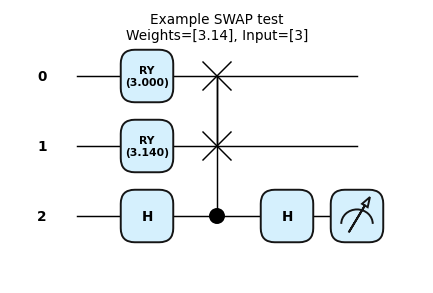

Single model result: 0.995 for ([3.14] vs [3])
High similarity cost (~0.0): 0.001  for ([3.14] vs [[3], [3.1], [3.14]])
Low  similarity cost (~0.5): 0.321  for ([3.14] vs [[-1.2], [2.1], [0.14]])


In [15]:
### Testing cost function
if debug:
    test_dev = qml.device(sim, wires=3, seed=seed, shots=shots)
    @qml.qnode(test_dev, interface=interface, diff_method=diff_method)
    def swap_test_circuit(weights, inputs):
        ancilla_wire = 2; target_wire = 0; variational_wire = 1
        qml.RY(inputs[0], wires=target_wire)
        qml.RY(weights[0], wires=variational_wire)
        qml.Hadamard(wires=ancilla_wire)
        qml.CSWAP(wires=[ancilla_wire, target_wire, variational_wire])
        qml.Hadamard(wires=ancilla_wire)
        return qml.expval(qml.PauliZ(ancilla_wire))

    test_weights = [3.14]
    test_single = [3]
    test_input1 = [[3], [3.1], [3.14]]
    test_input2 = [[-1.2], [2.1], [0.14]]
    draw_circuit(swap_test_circuit, scale=0.7, fontsize=14, decimals=3, 
        title=f'Example SWAP test\nWeights={test_weights}, Input={test_single}', 
        level='device')(test_weights, test_single)
    test_cost = cost_fun_gen_on_probs(swap_test_circuit, cost_probs_on_ancila)
    print(f'Single model result: {float(np.round(swap_test_circuit(test_weights, [3]), 3))} '+\
          f'for ({[float(np.round(num, 3)) for num in test_weights]} vs {test_single})')
    print(f'High similarity cost (~0.0): {test_cost(test_weights, test_input1):0.3f}  '+\
          f'for ({[float(np.round(num, 3)) for num in test_weights]} vs {test_input1})')
    print(f'Low  similarity cost (~0.5): {test_cost(test_weights, test_input2):0.3f}  '+\
          f'for ({[float(np.round(num, 3)) for num in test_weights]} vs {test_input2})');

### <font color="red">Sequential block of angle encoding</font>
- Use only to test sequence_encoder

In [16]:
def qae_seq_model(wires, n_data_wires, n_inputs):
    n_wires = len(wires)

    def _qae_seq_model(inputs):
        nonlocal n_wires, n_data_wires, n_inputs
        data_wires = wires[:n_data_wires]
        sequence_encoder(data_wires, inputs)
        return [qml.expval(qml.PauliZ(m)) for m in data_wires]
    return _qae_seq_model


Amplitude input data (4,): 
[0.5, 0.75, -0.25, -0.1]

Angular input data (4,): 
[1.04719755 0.72273425 1.82347658 1.67096375]



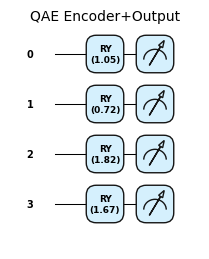

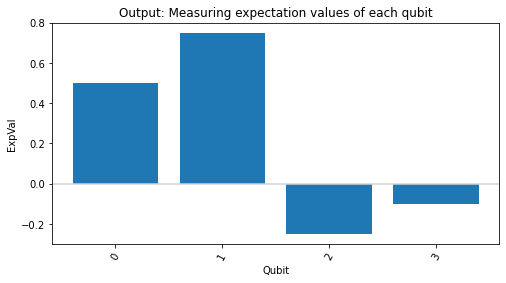

In [17]:
if debug:
    test_n_latent = 2; test_n_trash = 2
    test_n_inputs = test_n_latent + test_n_trash
    test_n_wires = test_n_latent + test_n_trash
    test_wires = list(range(test_n_wires))
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude input data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular input data {test_data.shape}: \n{test_data}\n')
    
    ### Testing QAE encoder
    
    # Define a static QAE encoder
    test_qae_seq = qae_seq_model(test_wires, test_n_wires, test_n_wires)
    
    # Create and draw a QAE encoder
    test_dev = qml.device(sim, wires=range(test_n_wires), seed=seed, shots=shots)
    test_qae_seq_qc = qml.QNode(test_qae_seq, test_dev, interface=interface, diff_method=diff_method)
    draw_circuit(test_qae_seq_qc, scale=0.5, title='QAE Encoder+Output', level='device')(test_data)

    # Plot the results
    expvals = test_qae_seq_qc(test_data)
    plot_hist(expvals, figsize=(8, 4), ylabel='ExpVal', xlabel='Qubit',
              title='Output: Measuring expectation values of each qubit',
              labels=[str(i) for i in range(len(test_data))])

## <font color="red">Inverted half-QAE decoder</font>
- As decoder is an inverted encoder, it is inverted(inverted(entangler)) = entangler
- Training is on SWAP test of trash (with measurement)

### Model definition

In [18]:
def qae_inv_decoder_model_shape(n_latent, n_trash, n_layers=1, rot='Ry'):
    return entangler_shape(n_layers, n_latent+n_trash, rot=rot)

def qae_inv_dencoder_model(wires, n_latent, n_trash, n_layers=1, rot='Ry', invert=False):

    n_zero = n_trash
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    zero_wires = wires[n_latent+n_trash:n_latent+n_trash+n_zero]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires
    ancila_wire = wires[-1]

    ### Full QAE encoder
    def _qae_inv_decoder(weights, inputs):
        
        nonlocal wires, n_latent, n_trash, n_zero, n_layers, rot
        nonlocal latent_wires, trash_wires, zero_wires, data_wires, anz_wires, ancila_wire
        nonlocal invert

        # Add inverted input encoder (pure data)
        sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)

        # Add entangling block
        entangler(weights, anz_wires, rot=rot)
  
        # Add swap space
        qml.Barrier(wires)
        swap_test(trash_wires, zero_wires, ancila_wire)
        qml.Barrier(wires)

        return qml.expval(qml.PauliZ(ancila_wire))

    return _qae_inv_decoder

### Model testing


Amplitude data (4,): 
[0.5, 0.75, -0.25, -0.1]

Angular data (4,): 
[1.04719755 0.72273425 1.82347658 1.67096375]

QAE inv decoder shape: (2, 4, 3), weights: 24

Data (4,): 
[1.04719755 0.72273425 1.82347658 1.67096375]

Weights (2, 4, 3): 
[[[0.13548816 0.8878517  0.93260564]
  [0.44556816 0.38823555 0.25759644]
  [0.65736759 0.49261694 0.96423842]
  [0.80098447 0.45520529 0.80105809]]

 [[0.04171797 0.76945787 0.00317112]
  [0.29280939 0.61091433 0.91302739]
  [0.300115   0.24859864 0.6663921 ]
  [0.98753291 0.46827041 0.12328738]]]



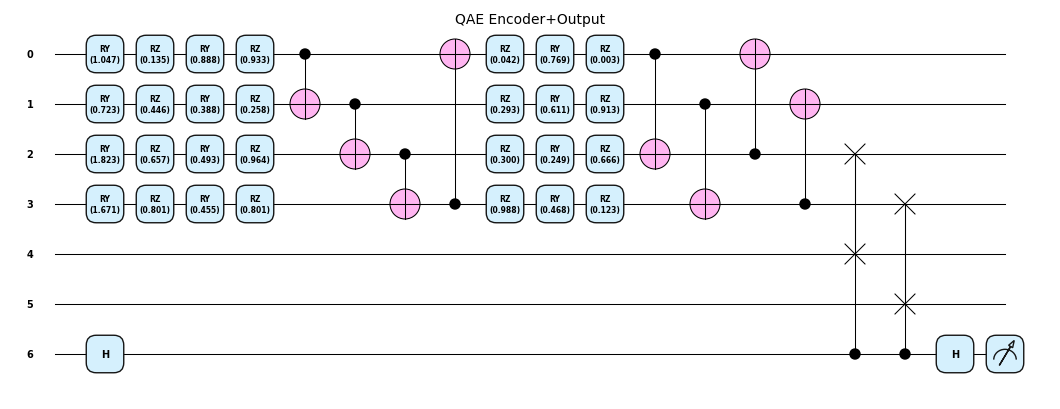

In [19]:
### Testing inverted decoder structure with SWAP test
if debug:
    test_n_latent = 2; test_n_trash = 2; test_n_layers=2
    test_n_inputs = test_n_latent + test_n_trash
    test_n_wires = test_n_latent + 2*test_n_trash + 1
    test_wires = list(range(test_n_wires))
    test_rot = 'Rxyz'
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular data {test_data.shape}: \n{test_data}\n')
    
    test_shape = qae_inv_decoder_model_shape(test_n_latent, test_n_trash, test_n_layers, test_rot)
    test_n_weights = np.prod(test_shape)
    print(f'QAE inv decoder shape: {test_shape}, weights: {int(test_n_weights)}\n')
    
    # test_data = np.linspace(100, 200, test_n_inputs, requires_grad=False)
    test_weights = np.random.rand(*test_shape, requires_grad=True)
    
    print(f'Data {test_data.shape}: \n{test_data}\n')
    print(f'Weights {test_weights.shape}: \n{test_weights}\n')
    
    ### Testing QAE encoder
    
    # Define a static QAE encoder
    test_qae_inv_decoder = qae_inv_dencoder_model(test_wires, test_n_latent, test_n_trash, 
        test_n_layers, test_rot, invert=True)
    
    # Create and draw a QAE encoder
    test_dev = qml.device(sim, wires=range(test_n_wires+2*test_n_trash+1), seed=seed, shots=shots)
    test_qae_inv_decoder_qc = qml.QNode(test_qae_inv_decoder, test_dev, interface=interface, diff_method=diff_method)
    draw_circuit(test_qae_inv_decoder_qc, scale=0.5, decimals=3, title='QAE Encoder+Output', level='device') \
        (test_weights, test_data) # expansion_strategy='device'/'gradient'

## <font color="red">Sidekick model</font>
- Consists of sequence + inverted decoder || sequence + encoder || swap test
- As decoder is inverted decoder = inverted(inverted(entangler)) = entangler
- As decoder has already been trained it weights are fixed and added to sidekick at creation
- Synchronisation is with SWAP test between latent areas (with measurement)

### Model definition
- Sidekick inv decoder weights are fixed, so only encoder weights are used

In [20]:
### Definition of shape and model
def qae_sidekick_model_shape(n_latent, n_trash, n_layers=1, rot='Ry'):
    return entangler_shape(n_layers, n_latent+n_trash, rot=rot)

def qae_sidekick_model(wires, dec_weights, n_latent, n_trash, n_layers=1, rot='Ry'):

    n_enc_start = n_latent + n_trash
    
    dec_latent_wires = wires[0:n_latent]
    dec_trash_wires = wires[n_latent:n_latent+n_trash]  
    dec_wires = dec_latent_wires + dec_trash_wires
    
    enc_latent_wires = wires[n_enc_start:n_enc_start+n_latent]
    enc_trash_wires = wires[n_enc_start+n_latent:n_enc_start+n_latent+n_trash]
    enc_wires = enc_latent_wires + enc_trash_wires
    
    ancila_wire = wires[-1]

    ### Sidekick encoder 
    #   If decoder fixed weights not provided, encoder weights will be used
    #   inputs need to be divided in half, first half for decoder and second for encoder
    def _qae_sidekick(weights, inputs):
        
        nonlocal wires, n_latent, n_trash, n_layers, rot #, n_zero
        nonlocal dec_latent_wires, dec_trash_wires, enc_latent_wires, enc_trash_wires
        nonlocal dec_wires, enc_wires, ancila_wire, dec_weights

        # Split inputs - must be enough for both
        n_inputs = len(inputs) // 2
        dec_inputs = inputs[:n_inputs]
        enc_inputs = inputs[n_inputs:]

        # Add inverted decoder (pure data)
        # However, decoder is an inverted entangler, so it is entangler
        sequence_encoder(dec_wires, dec_inputs)
        entangler(dec_weights, dec_wires, rot=rot)
  
        # Add encoder (noisy data)
        sequence_encoder(enc_wires, enc_inputs)
        entangler(weights, enc_wires, rot=rot)
  
        # Add swap space
        qml.Barrier(wires)
        swap_test(dec_latent_wires, enc_latent_wires, ancila_wire)
        qml.Barrier(wires)

        return qml.expval(qml.PauliZ(ancila_wire))

    return _qae_sidekick

### Model testing


Amplitude data (4,): 
[0.5, 0.75, -0.25, -0.1]

Angular data (4,): 
[1.04719755 0.72273425 1.82347658 1.67096375]

Sidekick QAE shape: (2, 4, 3), weights: 24

Data (8,): 
[1.04719755 0.72273425 1.82347658 1.67096375 1.04719755 0.72273425
 1.82347658 1.67096375]

Decoder Fixed Weights (2, 4, 3): 
[[[100 101 102]
  [103 104 105]
  [106 107 108]
  [109 110 111]]

 [[112 113 114]
  [115 116 117]
  [118 119 120]
  [121 122 123]]]

Encoder Init  Weights (2, 4, 3): 
[[[0.91603139 0.94614353 0.27769737]
  [0.51965369 0.154745   0.01462735]
  [0.32424321 0.99089844 0.51314129]
  [0.87649564 0.06739575 0.28415374]]

 [[0.46889927 0.76177319 0.92261178]
  [0.39302376 0.92908768 0.49961201]
  [0.80204969 0.89658011 0.48212908]
  [0.8479299  0.27667928 0.34022921]]]



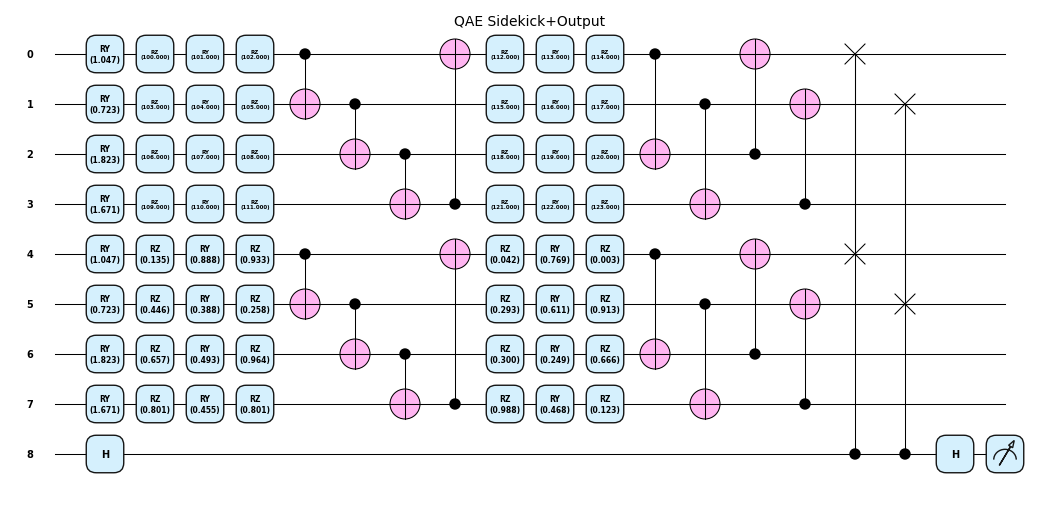

In [21]:
### Testing Sidekick structure with SWAP test
if debug:
    test_n_latent = 2; test_n_trash = 2; test_n_layers=2
    test_n_inputs = test_n_latent + test_n_trash # but need twice as much
    test_n_wires = 2*(test_n_latent + test_n_trash) + 1
    test_wires = list(range(test_n_wires))
    test_rot = 'Rxyz'
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular data {test_data.shape}: \n{test_data}\n')
    
    test_dec_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot) # Fixed weights
    test_enc_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot)
    test_n_weights = np.prod(test_enc_shape)
    print(f'Sidekick QAE shape: {test_enc_shape}, weights: {int(test_n_weights)}\n')
    
    # Create 1 data point
    test_dec_data = test_data # np.linspace(-i*np.pi/10, -(i+1)*np.pi/10, test_n_inputs, requires_grad=False)
    test_enc_data = test_data # np.linspace(i*np.pi/10, (i+1)*np.pi/10, test_n_inputs, requires_grad=False)
    test_sidekick_data = np.array([*test_dec_data, *test_enc_data])
    
    test_dec_init_weights = np.array([100+i for i in range(test_n_weights)]).reshape(*test_dec_shape) # Fixed weights
    test_enc_init_weights = np.random.rand(*test_enc_shape, requires_grad=True)
    
    print(f'Data {test_sidekick_data.shape}: \n{test_sidekick_data}\n')
    print(f'Decoder Fixed Weights {test_dec_init_weights.shape}: \n{test_dec_init_weights}\n')
    print(f'Encoder Init  Weights {test_enc_init_weights.shape}: \n{test_enc_init_weights}\n')
    
    ### Testing sidekick QAE
    
    # Define a static sidekick QAE encoder
    test_qae_sidekick = qae_sidekick_model(test_wires, test_dec_init_weights,
        test_n_latent, test_n_trash, test_n_layers, test_rot)
    
    # Create and draw a sidekick-QAE
    test_dev = qml.device(sim, wires=range(2*(test_n_wires+test_n_trash)+1), seed=seed, shots=shots)
    test_qae_sidekick_qc = qml.QNode(test_qae_sidekick, test_dev, interface=interface, diff_method=diff_method)
    draw_circuit(test_qae_sidekick_qc, scale=0.5, decimals=3, title='QAE Sidekick+Output', level='device') \
        (test_weights, test_sidekick_data) # expansion_strategy='device'/'gradient'

## <font color="red">Full QAE reintegrated model</font>
- Consists of sequence + decoder + encoder
- Encoder is an entangler
- Decoder is a mirror image of encoder, so it is inverted(entangler)
- As encoder and decoder have already been trained, there are no trainable weights
- Trash is SWAP with zeroe qubits (no measurement)

_Add sidekick fixed weights to encoder and decoder at creation_

### Model definition

In [22]:
def qae_full_model(wires, enc_weights, dec_weights, n_latent, n_trash, n_layers, rot):

    n_zero = n_trash
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    zero_wires = wires[n_latent+n_trash:n_latent+n_trash+n_zero]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires

    ### Full QAE encoder
    def _qae_full(inputs):
        
        nonlocal wires, n_latent, n_trash, n_zero, n_layers, rot
        nonlocal latent_wires, trash_wires, zero_wires, data_wires, anz_wires
        nonlocal enc_weights, dec_weights

        # Add encoder
        sequence_encoder(data_wires, inputs)
        entangler(enc_weights, data_wires, rot=rot)
  
        # Add swap space
        qml.Barrier(wires)
        swap(trash_wires, zero_wires)
        qml.Barrier(wires)
  
        # Add decoder
        # However, decoder is an inverted entangler
        qml.adjoint(entangler)(dec_weights, data_wires, rot=rot)

        # Convert the final values to their adjoint
        for q in data_wires:
            qml.PauliX(wires=q)

        return [qml.expval(qml.PauliZ(m)) for m in data_wires]

    return _qae_full

### Testing full-QAE structure


Amplitude data (4,): 
[0.5, 0.75, -0.25, -0.1]

Angular data (4,): 
[1.04719755 0.72273425 1.82347658 1.67096375]

Full QAE fixed shape: (2, 4, 3)+(2, 4, 3), weights: 48

Data (4,): 
[1.04719755 0.72273425 1.82347658 1.67096375]

Encoder Init  Weights (2, 4, 3): 
[[[0.1050746  0.52314772 0.64850802]
  [0.89961158 0.10386594 0.31174468]
  [0.07810332 0.93787019 0.95908699]
  [0.19124218 0.95402114 0.44404827]]

 [[0.26342439 0.66989772 0.37626831]
  [0.98546613 0.6670733  0.9914674 ]
  [0.97356447 0.18145632 0.441372  ]
  [0.67279338 0.65356758 0.38303924]]]

Decoder Fixed Weights (2, 4, 3): 
[[[100 101 102]
  [103 104 105]
  [106 107 108]
  [109 110 111]]

 [[112 113 114]
  [115 116 117]
  [118 119 120]
  [121 122 123]]]



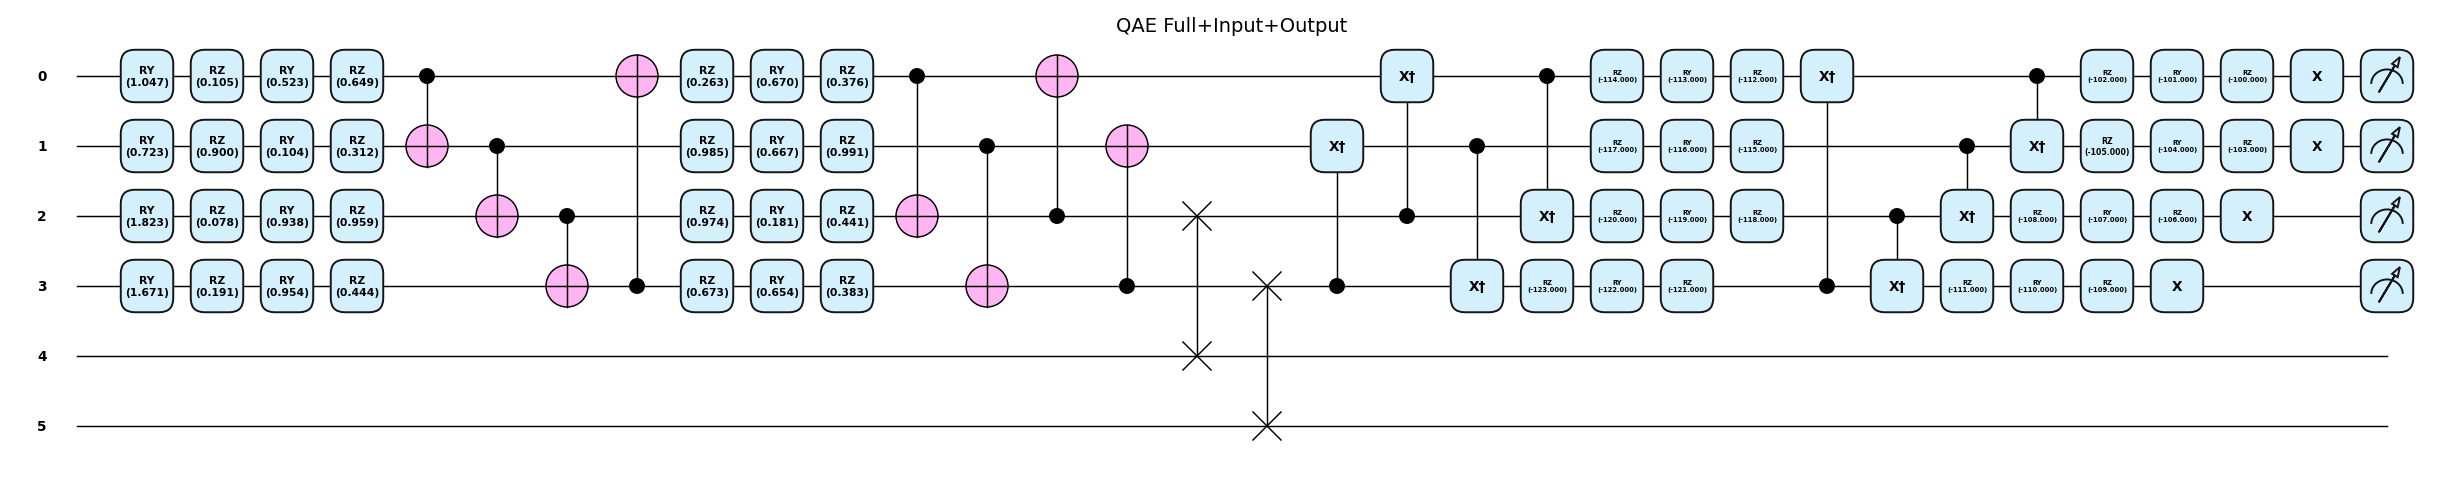

In [23]:
### Testing full-QAE structure
if debug:
    
    ### Test full-QAE structure
    test_n_latent = 2; test_n_trash = 2; test_n_layers=2
    test_n_inputs = test_n_latent + test_n_trash # but need twice as much
    test_n_wires = test_n_latent + 2*test_n_trash
    test_wires = list(range(test_n_wires))
    test_rot = 'Rxyz'
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular data {test_data.shape}: \n{test_data}\n')
    
    test_dec_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot) # Fixed weights
    test_enc_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot) # Fixed weights
    test_n_weights = np.prod(test_enc_shape)
    print(f'Full QAE fixed shape: {test_enc_shape}+{test_dec_shape}, weights: {int(2*test_n_weights)}\n')
    
    test_dec_init_weights = np.array([100+i for i in range(test_n_weights)]).reshape(*test_dec_shape) # Fixed weights
    test_enc_init_weights = np.random.rand(*test_enc_shape, requires_grad=True)
    
    print(f'Data {test_data.shape}: \n{test_data}\n')
    print(f'Encoder Init  Weights {test_enc_init_weights.shape}: \n{test_enc_init_weights}\n')
    print(f'Decoder Fixed Weights {test_dec_init_weights.shape}: \n{test_dec_init_weights}\n')
    
    ### Testing full QAE
    
    # Define a static QAE encoder
    test_qae_full = qae_full_model(test_wires, test_enc_init_weights, test_dec_init_weights,
        test_n_latent, test_n_trash, test_n_layers, test_rot)
    
    # Create and draw a full-QAE, add wires for SWAP space (only latent area goes through)
    test_dev = qml.device(sim, wires=range(2*(test_n_wires+test_n_trash)+1), seed=seed, shots=shots)
    test_qae_full_qc = qml.QNode(test_qae_full, test_dev)
    draw_circuit(test_qae_full_qc, scale=0.7, decimals=3, title='QAE Full+Input+Output', level='device') \
        (test_data) # expansion_strategy='device'/'gradient'

### Testing full-QAE function


Amplitude data (4,): 
[0.5, 0.75, -0.25, -0.1]

Angular data (4,): 
[1.04719755 0.72273425 1.82347658 1.67096375]

Full QAE fixed shape: (2, 4, 3)+(2, 4, 3), weights: 48

Data (4,): 
[1.04719755 0.72273425 1.82347658 1.67096375]

Encoder Fixed Weights (2, 4, 3): 
[[[0.         0.26179939 0.52359878]
  [0.78539816 1.04719755 1.30899694]
  [1.57079633 1.83259571 2.0943951 ]
  [2.35619449 2.61799388 2.87979327]]

 [[3.14159265 3.40339204 3.66519143]
  [3.92699082 4.1887902  4.45058959]
  [4.71238898 4.97418837 5.23598776]
  [5.49778714 5.75958653 6.02138592]]]

Decoder Fixed Weights (2, 4, 3): 
[[[0.         0.26179939 0.52359878]
  [0.78539816 1.04719755 1.30899694]
  [1.57079633 1.83259571 2.0943951 ]
  [2.35619449 2.61799388 2.87979327]]

 [[3.14159265 3.40339204 3.66519143]
  [3.92699082 4.1887902  4.45058959]
  [4.71238898 4.97418837 5.23598776]
  [5.49778714 5.75958653 6.02138592]]]

Test result:  ['-0.500', '-0.750', '0.250', '0.100'] 



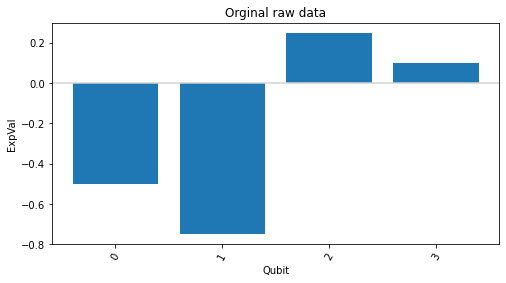

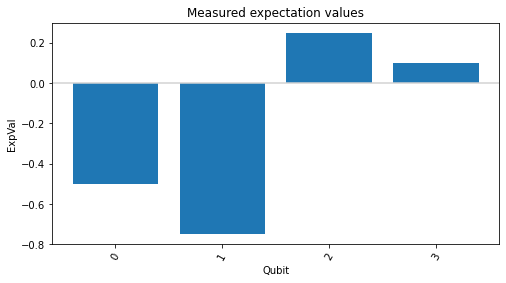

In [24]:
### Testing full-QAE function
#   Without trash in QAE with mirrored weights, information can be fully recovered
if debug:
    
    test_n_latent = 4; test_n_trash = 0; test_n_layers=2
    test_n_inputs = test_n_latent + test_n_trash # but need twice as much
    test_n_wires = test_n_latent + 2*test_n_trash
    test_wires = list(range(test_n_wires))
    test_rot = 'Rxyz'
    
    raw_data = [0.5, 0.75, -0.25, -0.1]
    test_data = np.array([np.arccos(x) for x in raw_data], requires_grad=False)
    print(f'\nAmplitude data {test_data.shape}: \n{raw_data}\n')
    print(f'Angular data {test_data.shape}: \n{test_data}\n')
    
    test_enc_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot)
    test_dec_shape = entangler_shape(test_n_layers, test_n_latent+test_n_trash, test_rot) # Mirror structure
    test_n_weights = np.prod(test_enc_shape)
    print(f'Full QAE fixed shape: {test_enc_shape}+{test_dec_shape}, weights: {int(2*test_n_weights)}\n')
    
    test_dec_init_weights = \
        np.array([2*np.pi/test_n_weights*i for i in range(test_n_weights)], requires_grad=True).reshape(*test_dec_shape) # Fixed weights
    test_enc_init_weights = test_dec_init_weights # Mirror weights
    
    print(f'Data {test_data.shape}: \n{test_data}\n')
    print(f'Encoder Fixed Weights {test_enc_init_weights.shape}: \n{test_enc_init_weights}\n')
    print(f'Decoder Fixed Weights {test_dec_init_weights.shape}: \n{test_dec_init_weights}\n')
    
    ### Testing full QAE
    
    # Define a static QAE encoder
    test_qae_full = qae_full_model(test_wires, test_enc_init_weights, test_dec_init_weights,
        test_n_latent, test_n_trash, test_n_layers, test_rot)
    
    # Create and draw a full-QAE, add wires for SWAP space (only latent area goes through)
    test_dev = qml.device(sim, wires=range(2*(test_n_wires+test_n_trash)+1), seed=seed, shots=shots)
    test_qae_full_qc = qml.QNode(test_qae_full, test_dev, interface=interface, diff_method=diff_method)
    result = np.stack(test_qae_full_qc(test_data))
    print('Test result: ',[f'{val:.3f}' for val in result], '\n')
    
    plot_hist(result, figsize=(8, 4), ylabel='ExpVal', xlabel='Qubit',
              title='Orginal raw data',
              labels=[str(i) for i in range(len(raw_data))])
    plot_hist(result, figsize=(8, 4), ylabel='ExpVal', xlabel='Qubit',
              title='Measured expectation values',
              labels=[str(i) for i in range(len(test_data))])

# <font color="blue">Model training</font>

## <font color="red">Inverted decoder training</font>

### Training loop

In [25]:
##### Training loop

def train_dec_without_noise(model, X, cost_fun, optimizer, n_epochs, init_weights, 
    log_interv=1, prompt_fract=0.1, start_time=0, level=2, seed=0, scale_low=0.1, scale_high=0.9,
    wind_size=8, wind_step=4, noise=0, weight_scaler=0.1):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    params = weight_scaler*init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, X, noise=0, seed=seed,
        wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, y_pure_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):04d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

### Model preparation for training
- Here we have an invverted decoder (so it is an inverted(inverted(entangler)))
- Decoder is to be trained, so all its weights are trainable
- Decoder weights are created in range [-2*pi, 2*pi] but subject to weight_scaler multiplier (0.1)

QAE inv decoder shape: (4, 6, 3), weights: 72

Weights shape: (4, 6, 3)
Pure data y shape: (74, 6)
Wires (9): [0, 1, 2, 3, 4, 5, 6, 7, 8]



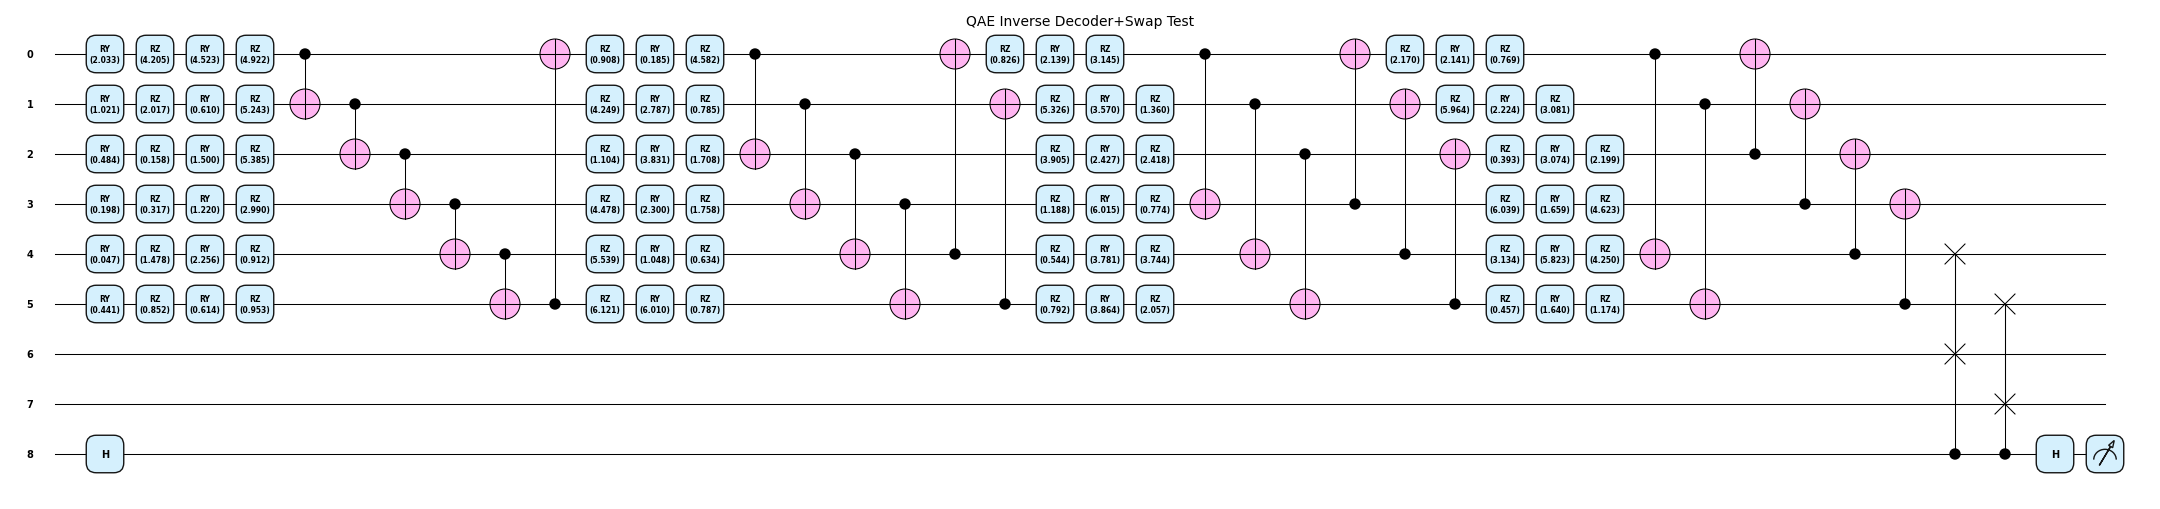

In [26]:
### Traing the inverted decoder
inv_decoder_shape = qae_inv_decoder_model_shape(n_latent, n_trash, n_layers, rot)
inv_decoder_n_weights = np.prod(inv_decoder_shape)
print(f'QAE inv decoder shape: {inv_decoder_shape}, weights: {int(inv_decoder_n_weights)}\n')

inv_decoder_init_weights = np.random.rand(*inv_decoder_shape, requires_grad=True)*2*np.pi
print(f'Weights shape: {inv_decoder_init_weights.shape}')

### Pure data for training
print(f'Pure data y shape: {y_train_tens.shape}')

### Quantum simulator
inv_decoder_n_wires = n_latent+2*n_trash+1
inv_decoder_wires = list(range(inv_decoder_n_wires))
print(f'Wires ({inv_decoder_n_wires}): {inv_decoder_wires}\n')

# Define a static QAE encoder
qae_inv_decoder = qae_inv_dencoder_model(inv_decoder_wires, 
    n_latent, n_trash, n_layers, rot)

# Create and draw a QAE inverse decoder
inv_decoder_dev = qml.device(sim, wires=inv_decoder_wires, seed=seed, shots=shots)
qae_inv_decoder_qc = qml.QNode(qae_inv_decoder, inv_decoder_dev, interface=interface, diff_method=diff_method)
draw_circuit(qae_inv_decoder_qc, scale=0.5, decimals=3, title='QAE Inverse Decoder+Swap Test', level='device') \
    (inv_decoder_init_weights, y_train_tens[0])

### Training run

In [27]:
### For reproducibility
np.random.seed(seed)

### Preparation for training
opt = qml.AdamOptimizer(stepsize=n_inv_decoder_lr) # 0.05
cost_fun = cost_fun_gen_on_probs(qae_inv_decoder_qc, cost_probs_on_ancila)

### Training run
hist_cost, hist_params, init_weights, stats = train_dec_without_noise(
    qae_inv_decoder, X, cost_fun, opt, n_inv_decoder_epochs, inv_decoder_init_weights, 
    wind_size=wind_size, wind_step=wind_step, noise=0, weight_scaler=weight_scaler,
    prompt_fract=0.1, seed=seed, scale_low=y_low, scale_high=y_high)

Iter: 000 (0000 sec) cost=0.367652
Iter: 020 (0011 sec) cost=0.153435
Iter: 040 (0023 sec) cost=0.114163
Iter: 060 (0035 sec) cost=0.079716
Iter: 080 (0048 sec) cost=0.073959
Iter: 100 (0060 sec) cost=0.073219
Iter: 120 (0072 sec) cost=0.073073
Iter: 140 (0084 sec) cost=0.072983
Iter: 160 (0096 sec) cost=0.072849
Iter: 180 (0109 sec) cost=0.072709

Training completed: epochs=200, min cost=0.072591 @ 199, time=121 secs



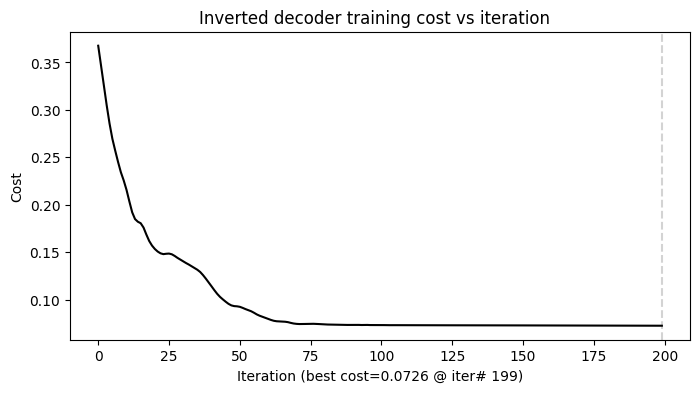

In [28]:
### Plot training cost
#   Note that best model may not have been saved
#   because models are being saved at predefined intervals (log_interv)
meas_plot(hist_cost, meas='cost', task='min', title_pref='Inverted decoder training',
    rcParams=(8, 4), log_interv=1,
    backplot=False, back_color='linen', smooth_weight=0.0)

In [29]:
inv_decoder_train_opt = int(stats[0])
inv_decoder_cost_opt = np.round(hist_cost[inv_decoder_train_opt], 5)
inv_decoder_costs = np.array(hist_cost)
inv_decoder_weights = np.array(hist_params)
inv_decoder_init_weights = np.array(init_weights)
inv_decoder_opt_weights = np.array(hist_params[inv_decoder_train_opt])
print(f'Finished training inverted decoder. Retained:\n')
print(f'Costs {inv_decoder_costs.shape}: {inv_decoder_cost_opt} @ {inv_decoder_train_opt}')
print(f'Weights {inv_decoder_weights.shape}')
print(f'Initial weights {inv_decoder_init_weights.shape}')
print(f'Optimum weights {inv_decoder_opt_weights.shape}')

Finished training inverted decoder. Retained:

Costs (200,): 0.07259 @ 199
Weights (200, 4, 6, 3)
Initial weights (4, 6, 3)
Optimum weights (4, 6, 3)


## <font color="red">Sidekick training</font>

In [30]:
##### Training loop
def train_sidekick_with_noise(model, X, cost_fun, optimizer, n_epochs, init_weights, 
    log_interv=1, prompt_fract=0.1, start_time=0, level=2, seed=0,
    wind_size=8, wind_step=4, noise=0, weight_scaler=0.1, scale_low=0.1, scale_high=0.9):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Prepare training
    hist_cost = []
    hist_params = []

    ### Initialise weights (note that model already knows of dec weights)
    params = weight_scaler*init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, seed=seed,
        wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, seed=seed+iter,
            wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)

        # Combine y and X into a single input tenspor
        y_X_combined = np.array([[*yts, *xts] for yts, xts in zip(y_pure_tens, X_noisy_tens)])
    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, y_X_combined), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):04d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

### Model preparation for training
- Decoder has been previously trained, so its weights are fixed
- Encoder is to be trained, so its weights are sidekick trainable
- Encoder weights are created in range [-2*pi, 2*pi] but are subject to weight_scaler multiplier (0.1)

Sidekick QAE shape: (4, 6, 3), weights: 72

Fixed inv decoder init weights shape: (4, 6, 3)
Trainable encoder init weights shape: (4, 6, 3)
Pure data y shape: (74, 6)

Wires (13): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]



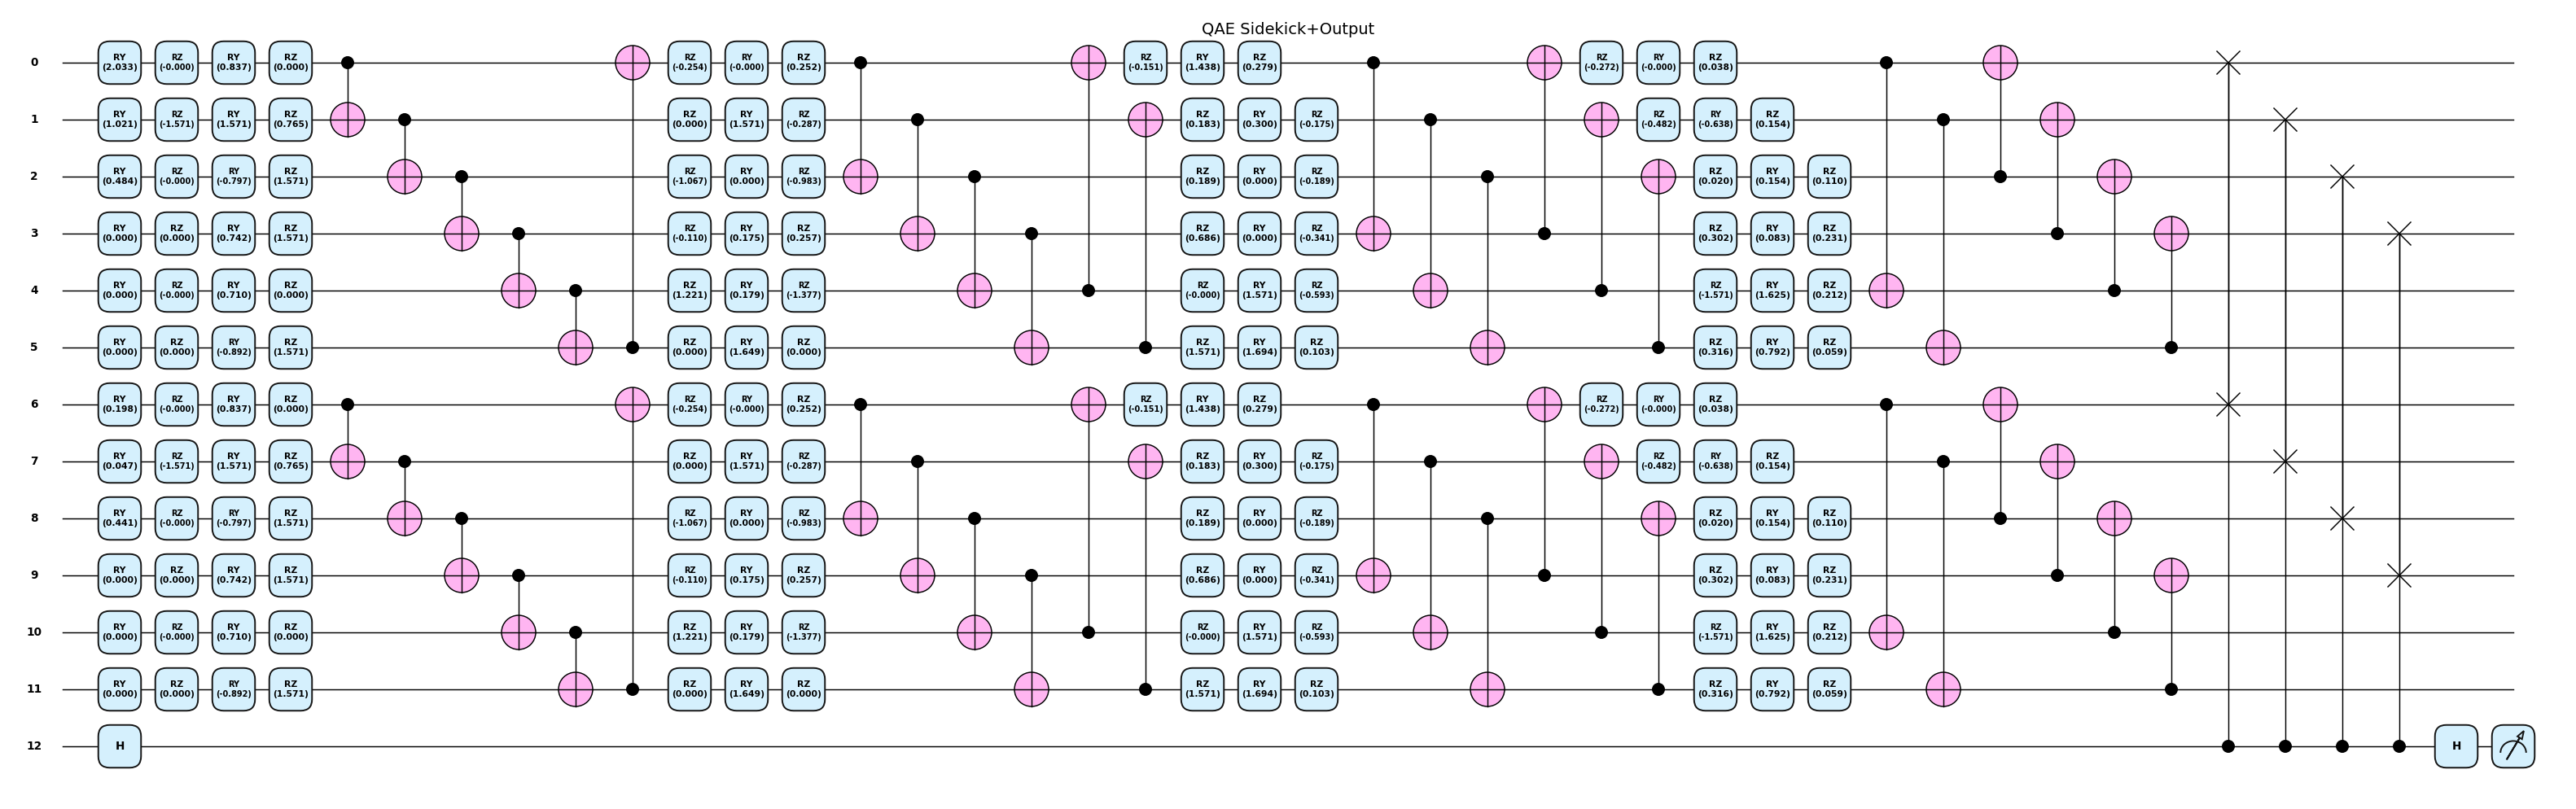

In [31]:
### Inspect model parameters
sidekick_dec_shape = entangler_shape(n_layers, n_latent+n_trash, rot) # Fixed weights
sidekick_enc_shape = entangler_shape(n_layers, n_latent+n_trash, rot)
sidekick_n_weights = np.prod(sidekick_enc_shape)
print(f'Sidekick QAE shape: {sidekick_enc_shape}, weights: {int(sidekick_n_weights)}\n')

### Preparing weight initialisation (also using fixed optimum decoder weights)
#   Two options considered for the encoder:
#   random - sidekick_init_weights = np.random.rand(*sidekick_enc_shape, requires_grad=True)*2*np.pi
#   mirror - sidekick_init_weights = inv_decoder_opt_weights.copy()
sidekick_init_weights = inv_decoder_opt_weights.copy()
print(f'Fixed inv decoder init weights shape: {inv_decoder_opt_weights.shape}')
print(f'Trainable encoder init weights shape: {sidekick_init_weights.shape}')

### Pure data for training
print(f'Pure data y shape: {y_train_tens.shape}\n')

### Wires requirements
sidekick_n_wires = 2*(n_latent+n_trash)+1
sidekick_wires = list(range(sidekick_n_wires))
print(f'Wires ({sidekick_n_wires}): {sidekick_wires}\n')

### Define a sidekick QAE
sidekick_dev = qml.device(sim, wires=sidekick_wires, seed=seed, shots=shots)
qae_sidekick = qae_sidekick_model(sidekick_wires, inv_decoder_opt_weights,
    n_latent, n_trash, n_layers, rot)
qae_sidekick_qc = qml.QNode(qae_sidekick, sidekick_dev, interface=interface, diff_method=diff_method)
draw_circuit(qae_sidekick_qc, scale=0.7, decimals=3, title='QAE Sidekick+Output', level='device') \
    (sidekick_init_weights, y_train_tens[0]) # expansion_strategy='device'/'gradient'

### Training run

In [32]:
### For reproducibility
np.random.seed(seed)

### Preparation for training
opt = qml.AdamOptimizer(stepsize=n_sidekick_lr)
cost_fun = cost_fun_gen_on_probs(qae_sidekick_qc, cost_probs_on_ancila)

### Training run
hist_cost, hist_params, init_weights, stats = train_sidekick_with_noise(
    qae_sidekick_qc, X, cost_fun, opt, n_sidekick_epochs, sidekick_init_weights, 
    wind_size=wind_size, wind_step=wind_step, noise=noise, weight_scaler=weight_scaler,
    prompt_fract=0.1, seed=seed, scale_low=y_low, scale_high=y_high)

Iter: 000 (0001 sec) cost=0.463775
Iter: 050 (0053 sec) cost=0.383345
Iter: 100 (0106 sec) cost=0.36632
Iter: 150 (0159 sec) cost=0.340907
Iter: 200 (0211 sec) cost=0.322063
Iter: 250 (0262 sec) cost=0.342861
Iter: 300 (0314 sec) cost=0.33361
Iter: 350 (0365 sec) cost=0.329534
Iter: 400 (0416 sec) cost=0.335915
Iter: 450 (0467 sec) cost=0.32465

Training completed: epochs=500, min cost=0.307292 @ 464, time=517 secs



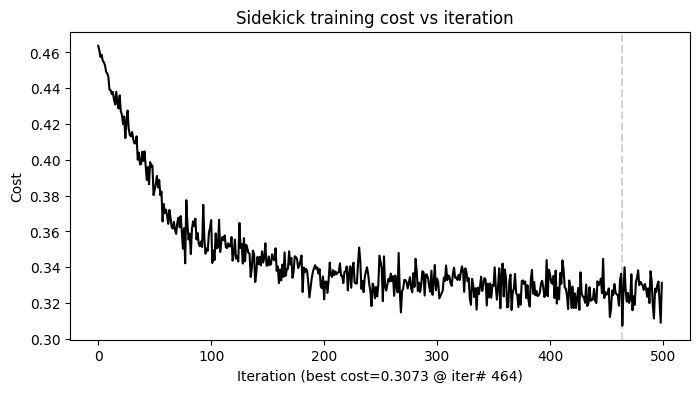

In [33]:
### Plot training cost
#   Note that best model may not have been saved
#   because models are being saved at predefined intervals (log_interv)
meas_plot(hist_cost, meas='cost', task='min', title_pref='Sidekick training',
    rcParams=(8, 4), log_interv=1,
    backplot=False, back_color='linen', smooth_weight=0.0)

In [34]:
sidekick_train_opt = int(stats[0])
sidekick_cost_opt = np.round(hist_cost[sidekick_train_opt], 5)
sidekick_costs = np.array(hist_cost)
sidekick_weights = np.array(hist_params)
sidekick_init_weights = np.array(init_weights)
sidekick_opt_weights = np.array(hist_params[sidekick_train_opt])
print(f'Finished training inverted decoder. Retained:\n')
print(f'\tCosts {sidekick_costs.shape}: {sidekick_cost_opt} @ {sidekick_train_opt}')
print(f'\tWeights {sidekick_weights.shape}')
print(f'\tInitial weights {sidekick_init_weights.shape}')
print(f'\tOptimum weights {sidekick_opt_weights.shape}')

Finished training inverted decoder. Retained:

	Costs (500,): 0.30729 @ 464
	Weights (500, 4, 6, 3)
	Initial weights (4, 6, 3)
	Optimum weights (4, 6, 3)


# <font color="blue">Model testing</font>
We have to remember that the original data was recoded from the range [0, 1] to the range [0, pi]. However, the full QAE results will be returned as expectation values in the range [-1, 1], so they have to be rescaled back to the range [0,1] for scoring, comparison and plotting.

### Model preparation


Training data (74, 6)
Full QAE fixed shape: (4, 6, 3)+(4, 6, 3), weights: 144
Encoder Fixed Weights (4, 6, 3)

Decoder Fixed Weights (4, 6, 3)


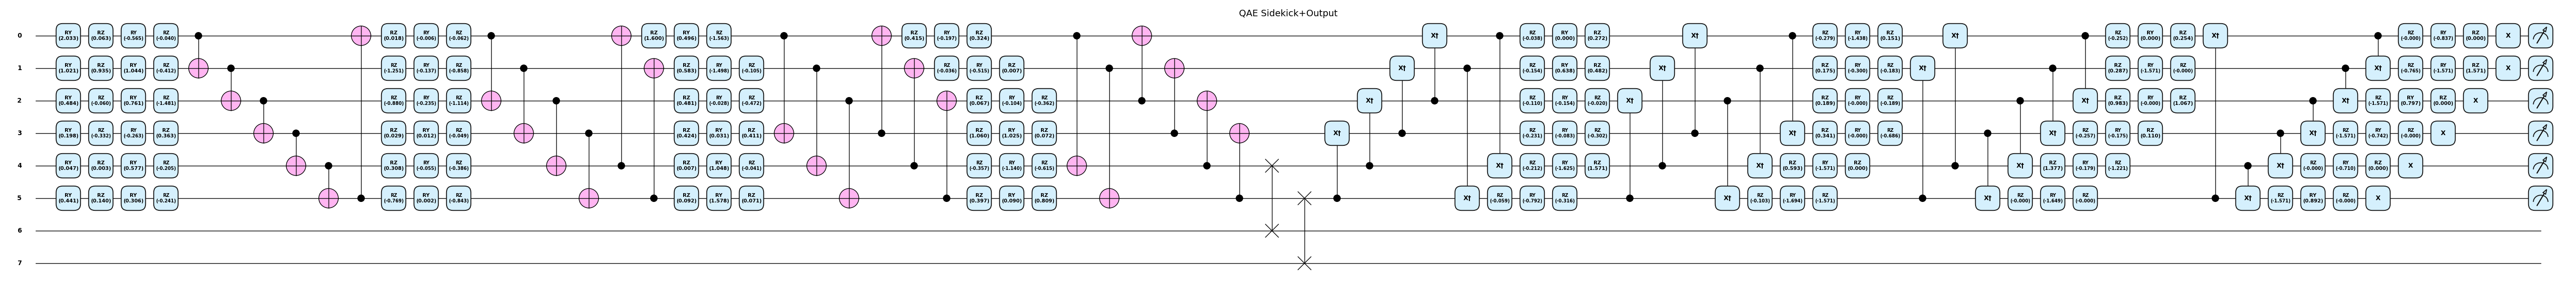

In [35]:
### Data preparation
qae_n_wires = n_latent + 2*n_trash
qae_wires = list(range(qae_n_wires))

qae_enc_shape = entangler_shape(n_layers, n_latent+n_trash, rot)
qae_dec_shape = entangler_shape(n_layers, n_latent+n_trash, rot) # Mirror structure
qae_n_weights = np.prod(qae_enc_shape)+np.prod(qae_dec_shape)

print(f'\nTraining data {y_train_tens.shape}')
print(f'Full QAE fixed shape: {qae_enc_shape}+{qae_dec_shape}, weights: {int(qae_n_weights)}')
print(f'Encoder Fixed Weights {sidekick_opt_weights.shape}\n')
print(f'Decoder Fixed Weights {inv_decoder_opt_weights.shape}')

### Create a full QAE

# Define a static QAE encoder
qae_full = qae_full_model(qae_wires, sidekick_opt_weights, inv_decoder_opt_weights,
    n_latent, n_trash, n_layers, rot)

# Create and draw a full-QAE
qae_dev = qml.device(sim, wires=qae_wires, seed=seed, shots=shots)
qae_full_qc = qml.QNode(qae_full, qae_dev, interface=interface, diff_method=diff_method)

draw_circuit(qae_full_qc, scale=0.7, decimals=3, title='QAE Sidekick+Output', level='device') \
    (y_train_tens[0]) # expansion_strategy='device'/'gradient'

### Flattening of time series data for scoring and plotting

In [36]:
### Reconstruct pure and noisy training TSs
pred_from_pure_train_tens = np.stack([qae_full_qc(x) for x in X_train_tens], requires_grad=False)
pred_from_pure_test_tens = np.stack([qae_full_qc(x) for x in X_test_tens], requires_grad=False)
pred_from_noisy_train_tens = np.stack([qae_full_qc(x) for x in X_train_noisy_tens], requires_grad=False)
pred_from_noisy_test_tens = np.stack([qae_full_qc(x) for x in X_test_noisy_tens], requires_grad=False)

### Flatten recovered TSs and recode their values to range [0..1]

# These were TS encoded in the range [0..pi]
X_train_flat_ts = ts_wind_flatten_avg(X_train_tens, wind_step)/np.pi
X_test_flat_ts = ts_wind_flatten_avg(X_test_tens, wind_step)/np.pi
X_train_noisy_flat_ts = ts_wind_flatten_avg(X_train_noisy_tens, wind_step)/np.pi
X_test_noisy_flat_ts = ts_wind_flatten_avg(X_test_noisy_tens, wind_step)/np.pi

# These TS were measured as expvals in the range [-1..1]
pred_from_pure_train_flat = (ts_wind_flatten_avg(pred_from_pure_train_tens, wind_step)+1)/2.0
pred_from_pure_test_flat = (ts_wind_flatten_avg(pred_from_pure_test_tens, wind_step)+1)/2.0
pred_from_noisy_train_flat = (ts_wind_flatten_avg(pred_from_noisy_train_tens, wind_step)+1)/2.0
pred_from_noisy_test_flat = (ts_wind_flatten_avg(pred_from_noisy_test_tens, wind_step)+1)/2.0

### Scoring of the model <font color="red">selected on training</font>

In [37]:
### Calculate metrics to show in charts
#   Note that all pure X = pure y, noise was injected into X only
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse_train_pure_vs_noisy = mean_squared_error(X_train_flat_ts, X_train_noisy_flat_ts)
mse_test_pure_vs_noisy = mean_squared_error(X_test_flat_ts, X_test_noisy_flat_ts)
mse_train_pure_vs_rec_from_pure = mean_squared_error(X_train_flat_ts, pred_from_pure_train_flat)
mse_test_pure_vs_rec_from_pure = mean_squared_error(X_test_flat_ts, pred_from_pure_test_flat)
mse_train_pure_vs_rec_from_noisy = mean_squared_error(X_train_flat_ts, pred_from_noisy_train_flat)
mse_test_pure_vs_rec_from_noisy = mean_squared_error(X_test_flat_ts, pred_from_noisy_test_flat)

In [38]:
print(f'MSE train (pure vs noise) ~ (pure vs recovered from pure) =  '+\
      f'{mse_train_pure_vs_noisy:0.4f} ~ {mse_train_pure_vs_rec_from_pure:0.4f}')
print(f'MSE test  (pure vs noise) ~ (pure vs recovered from pure) =  '+\
      f'{mse_test_pure_vs_noisy:0.4f} ~ {mse_test_pure_vs_rec_from_pure:0.4f}\n')

print(f'MSE train (pure vs noise) ~ (pure vs recovered from noisy) = '+\
      f'{mse_train_pure_vs_noisy:0.4f} ~ {mse_train_pure_vs_rec_from_noisy:0.4f}')
print(f'MSE test  (pure vs noise) ~ (pure vs recovered from noisy) = '+\
      f'{mse_test_pure_vs_noisy:0.4f} ~ {mse_test_pure_vs_rec_from_noisy:0.4f}')

MSE train (pure vs noise) ~ (pure vs recovered from pure) =  0.0413 ~ 0.0290
MSE test  (pure vs noise) ~ (pure vs recovered from pure) =  0.0323 ~ 0.0291

MSE train (pure vs noise) ~ (pure vs recovered from noisy) = 0.0413 ~ 0.0371
MSE test  (pure vs noise) ~ (pure vs recovered from noisy) = 0.0323 ~ 0.0321


### Plotting of data "recovery" from <font color="red">clean data</font>

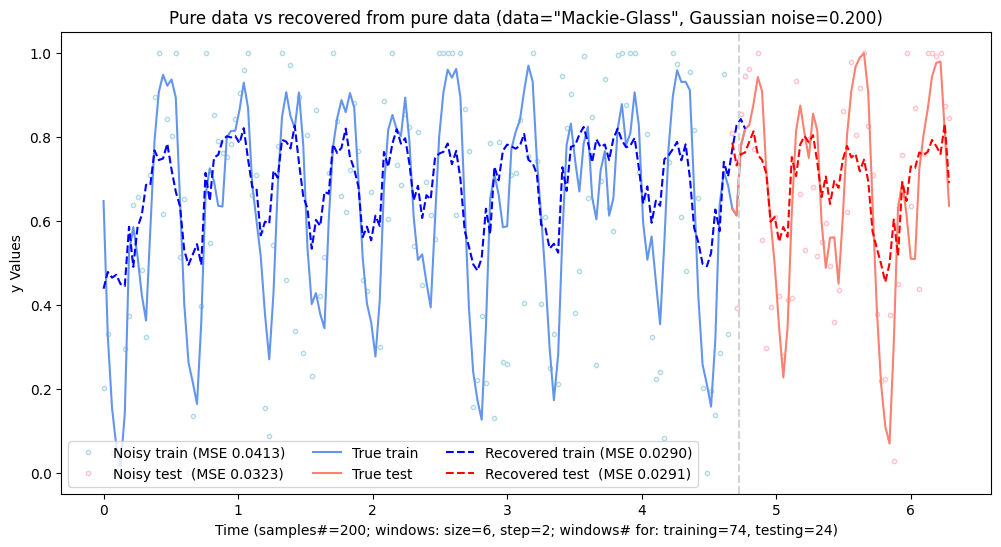

In [39]:
### Plot the original and recovered from pure data with added performance metrics
# exper_from_pure_train_flat = 4*(0.5-pred_from_pure_train_flat)+1
# exper_from_pure_test_flat = 4*(0.5-pred_from_pure_test_flat)+1

# Plot partitions
print()
# Plot partitions
print()
plt.figure(figsize=(12, 6))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, color="lightblue", linestyle='', mfc='white', marker='.', 
         label=f"Noisy train (MSE {mse_train_pure_vs_noisy:0.4f})")
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, color="pink", linestyle='', mfc='white', marker='.', 
         label=f"Noisy test  (MSE {mse_test_pure_vs_noisy:0.4f})")
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="cornflowerblue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="salmon")
plt.plot(X_train_flat_coords, pred_from_pure_train_flat, color="blue", linestyle='dashed', 
         label=f"Recovered train (MSE {mse_train_pure_vs_rec_from_pure:0.4f})")
plt.plot(X_test_flat_coords, pred_from_pure_test_flat, color="red", linestyle='dashed', 
         label=f"Recovered test  (MSE {mse_test_pure_vs_rec_from_pure:0.4f})")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='dashed')
plt.xlabel(f'Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('y Values')
plt.title(f'Pure data vs recovered from pure data (data="Mackie-Glass", Gaussian noise={noise:0.3f})')
plt.legend(loc='lower left', ncol=3)
plt.show()
print()

### Plotting of data recovery from <font color="red">noisy data</font>

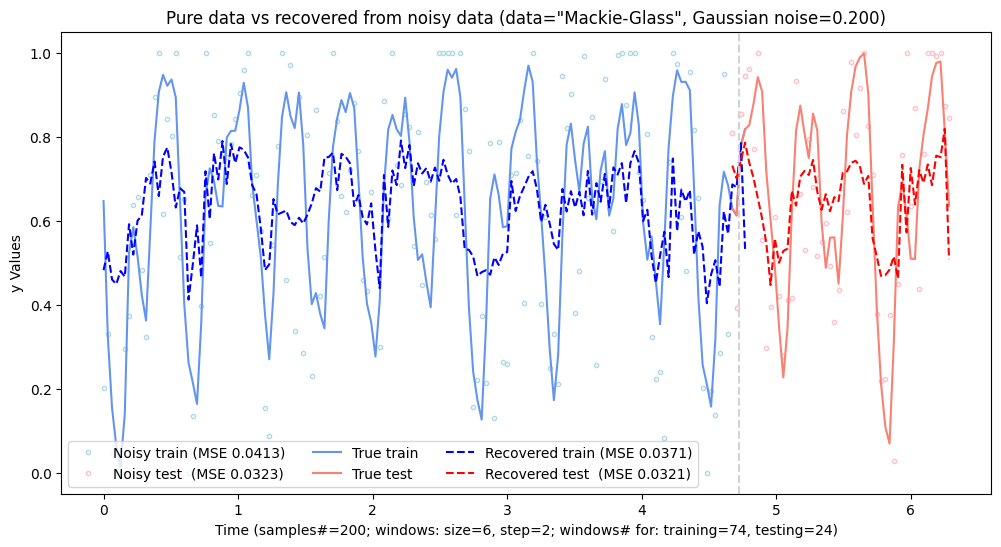

In [40]:
### Plot the original and recovered from noisy data with added performance metrics

# Plot partitions
print()
plt.figure(figsize=(12, 6))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, color="lightblue", linestyle='', mfc='white', marker='.', 
         label=f"Noisy train (MSE {mse_train_pure_vs_noisy:0.4f})")
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, color="pink", linestyle='', mfc='white', marker='.', 
         label=f"Noisy test  (MSE {mse_test_pure_vs_noisy:0.4f})")
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="cornflowerblue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="salmon")
plt.plot(X_train_flat_coords, pred_from_noisy_train_flat, color="blue", linestyle='dashed', 
         label=f"Recovered train (MSE {mse_train_pure_vs_rec_from_noisy:0.4f})")
plt.plot(X_test_flat_coords, pred_from_noisy_test_flat, color="red", linestyle='dashed', 
         label=f"Recovered test  (MSE {mse_test_pure_vs_rec_from_noisy:0.4f})")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='dashed')
plt.xlabel(f'Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('y Values')
plt.title(f'Pure data vs recovered from noisy data (data="Mackie-Glass", Gaussian noise={noise:0.3f})')
plt.legend(loc='lower left', ncol=3)
plt.show()
print()

# Software in use (Linux)

In [41]:
import os
os.system('pip list | grep -e pennylane -e torch');

pennylane                 0.42.3
pennylane_lightning       0.42.0
torch                     2.8.0
torchaudio                2.8.0
torcheval                 0.0.7
torchmetrics              1.8.2
torchsummary              1.5.1
torchvision               0.23.0
